In [1]:
import numpy as np
import pandas as pd
import torch
import os, sys
sys.path.append(os.path.realpath('./src/'))

import time
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon, Ellipse
from smallestEllipse import *

from utilFuncs import to_np, to_torch
from materialEncoder import MaterialEncoder


import scipy as sp

#matplotlib qt



In [2]:
def preprocessData():
    # Load your data
    df = pd.read_excel('./ratio_rhoyoung_computed_material_7_final_pure_only.xlsx')

    # Keep track of 'family' 
    dataIdentifier = {'material': df['material'],'classID':df['index']}

    # Select the properties you want to model (features)
    feature_columns = ['rho_eff', 'cost', 'energy', 'waste', 'ratio_rho_over_E', 'yield_stress']
    trainInfo = np.log10(df[feature_columns].to_numpy())

    # Normalize to [0, 1]
    dataScaleMax = torch.tensor(np.max(trainInfo, axis=0))
    dataScaleMin = torch.tensor(np.min(trainInfo, axis=0))
    normalizedData = (torch.tensor(trainInfo) - dataScaleMin) / (dataScaleMax - dataScaleMin)
    trainingData = normalizedData.clone().float()

    # Create dataInfo for reference
    dataInfo = {
        'rho_eff': {'idx': 0, 'scaleMin': dataScaleMin[0], 'scaleMax': dataScaleMax[0]},
        'cost':    {'idx': 1, 'scaleMin': dataScaleMin[1], 'scaleMax': dataScaleMax[1]},
        'energy':  {'idx': 2, 'scaleMin': dataScaleMin[2], 'scaleMax': dataScaleMax[2]},
        'waste':   {'idx': 3, 'scaleMin': dataScaleMin[3], 'scaleMax': dataScaleMax[3]},
        'ratio_rho_over_E':   {'idx': 4, 'scaleMin': dataScaleMin[4], 'scaleMax': dataScaleMax[4]},
        'yield_stress':   {'idx': 5, 'scaleMin': dataScaleMin[5], 'scaleMax': dataScaleMax[5]},
    }

    return trainingData, dataInfo, dataIdentifier, trainInfo

trainingData, dataInfo, dataIdentifier, trainInfo = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape


In [3]:
latentDim, hiddenDim = 2, 250
numEpochs = 10000
klFactor = 4.5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}
materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)
start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate)
print('training time : {:.2F} '.format(time.perf_counter() - start))

cpu
Iter 0 reconLoss 5.07E+00 klLoss 4.07E-04 loss 5.07E+00
Iter 500 reconLoss 4.66E-03 klLoss 6.39E-03 loss 1.11E-02
Iter 1000 reconLoss 2.63E-03 klLoss 6.22E-03 loss 8.86E-03
Iter 1500 reconLoss 2.42E-03 klLoss 5.68E-03 loss 8.10E-03
Iter 2000 reconLoss 1.94E-03 klLoss 5.28E-03 loss 7.22E-03
Iter 2500 reconLoss 1.15E-03 klLoss 4.95E-03 loss 6.10E-03
Iter 3000 reconLoss 1.33E-03 klLoss 4.68E-03 loss 6.01E-03
Iter 3500 reconLoss 1.30E-03 klLoss 4.46E-03 loss 5.76E-03
Iter 4000 reconLoss 1.05E-03 klLoss 4.26E-03 loss 5.32E-03
Iter 4500 reconLoss 3.76E-03 klLoss 4.18E-03 loss 7.93E-03
Iter 5000 reconLoss 1.89E-03 klLoss 4.03E-03 loss 5.92E-03
Iter 5500 reconLoss 1.37E-03 klLoss 3.80E-03 loss 5.16E-03
Iter 6000 reconLoss 3.59E-03 klLoss 3.68E-03 loss 7.27E-03
Iter 6500 reconLoss 9.22E-04 klLoss 3.50E-03 loss 4.43E-03
Iter 7000 reconLoss 1.84E-03 klLoss 3.41E-03 loss 5.24E-03
Iter 7500 reconLoss 2.36E-03 klLoss 3.26E-03 loss 5.62E-03
Iter 8000 reconLoss 1.69E-03 klLoss 3.13E-03 loss 4.82E-

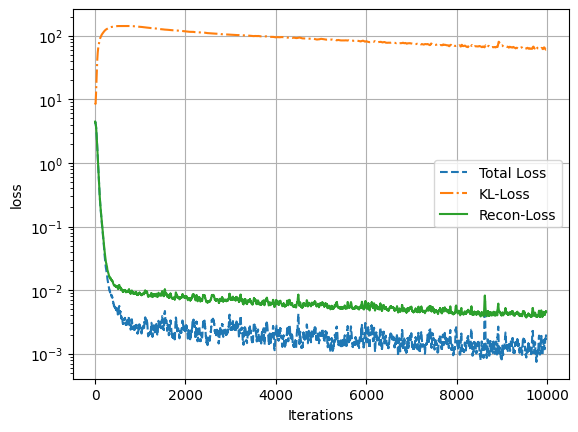

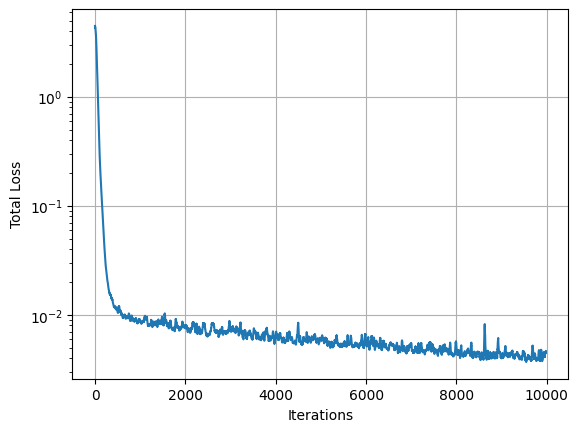

In [4]:
def plotConvergence(convg):
  plt.figure()
  strokes = ['--', '-.', '-', ':']
  for ctr, key in enumerate(convg):
    y = torch.as_tensor(convg[key]).detach().numpy()
    y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.
    plt.semilogy(y_mvavg, strokes[ctr], label = str(key))
    plt.xlabel('Iterations')
    plt.ylabel(str(key))
    plt.grid('True')
    plt.legend(labels={'KL-Loss','Recon-Loss','Total Loss'})
    # plt.legend('ReconLoss','KL-Loss','TotalLoss')
    plt.savefig('./figures/convergence.pdf',bbox_inches='tight')

plotConvergence(convgHistory)


def plotLoss(convg):
  plt.figure()
  y = torch.as_tensor(convg['loss']).detach().numpy()
  y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.
  plt.semilogy(y_mvavg, '-', label = 'Total Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Total Loss')
  plt.grid('True')
  # plt.legend(labels={'Total Loss'})

plotLoss(convgHistory)



In [5]:
props = {'rho_eff', 'cost', 'energy', 'waste', 'ratio_rho_over_E', 'yield_stress'}

def unnormalize(val, minval, maxval):
    return 10.**(minval + (maxval - minval) * val)

def decodeAll():
    vae = materialEncoder.vaeNet
    decoded = vae.decoder(vae.encoder.z)
    matProp = {}
    for k in props:
        idx = materialEncoder.dataInfo[k]['idx']
        scaleMax = materialEncoder.dataInfo[k]['scaleMax']
        scaleMin = materialEncoder.dataInfo[k]['scaleMin']
        matProp[k] = unnormalize(decoded[:, idx], scaleMin, scaleMax)
    return matProp

matProp = decodeAll()

print('\n----- Per-Material Reconstruction Table (First 10 Entries) -----\n')
header = f"{'Index':<5} {'Family':<20}"
for p in props:
    header += f"{p + ' (True)':>15} {p + ' (Recon)':>15} {p + ' %Err':>10}"
print(header)
print('-' * len(header))

maxError = {p: -1e10 for p in props}

# Limiting to the first 10 materials
num_entries_to_show = 10  # Change this to show more/less entries

for i in range(trainInfo.shape[0]):  # Only loop through the first 10 materials
    family = dataIdentifier['material'][i]
    row = f"{i:<5} {family:<20}"
    for p in props:
        idx = materialEncoder.dataInfo[p]['idx']
        true_val = 10**trainInfo[i, idx]
        recon_val = matProp[p][i].item()
        err_pct = abs(100 * (true_val - recon_val) / true_val)
        row += f"{true_val:15.3e} {recon_val:15.3e} {err_pct:10.2f}"

        # Update max error
        if err_pct > maxError[p]:
            maxError[p] = err_pct
    if i < num_entries_to_show:  # Only print the first 10 materials        
        print(row)

print('\n----- MAX Error per Property (%) -----')
for p in props:
    print(f"{p:<10}: {maxError[p]:.2f}")



----- Per-Material Reconstruction Table (First 10 Entries) -----

Index Family                 waste (True)   waste (Recon) waste %Errratio_rho_over_E (True) ratio_rho_over_E (Recon) ratio_rho_over_E %Erryield_stress (True) yield_stress (Recon) yield_stress %Err  energy (True)  energy (Recon) energy %Err rho_eff (True) rho_eff (Recon) rho_eff %Err    cost (True)    cost (Recon)  cost %Err
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0     Al 2024 pure              2.000e-01       2.003e-01       0.16      3.744e+01       3.691e+01       1.42      3.310e+02       3.332e+02       0.66      8.725e+02       8.983e+02       2.96      2.765e+03       2.815e+03       1.81      1.727e+01       1.720e+01       0.44
1 

In [6]:
merr = torch.tensor([0.])
meanError = {'rho_eff':merr,'cost':merr,\
             'energy':merr,'waste':merr, 'ratio_rho_over_E':merr, 'yield_stress':merr}

for i in range(trainInfo.shape[0]):
  # if(i in matidxs): #
  #   print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    trueData = 10**trainInfo[i,idx]
    reconData = matProp[p][i]
    err = torch.abs(100.*(trueData - reconData)/trueData).cpu()
    err = err.reshape((1,) + err.shape)
    meanError[p] = torch.cat((meanError[p],err),0)
    # meanError[p] = torch.cat([meanError[p],err],0)

print('\n \t -----Mean Error %----- \t ', end = '\n')
for p in props:
    print(p, end = '\t')
    print('\t {:.1F} \t'.format(torch.mean(meanError[p])), end='\n')


 	 -----Mean Error %----- 	 
waste		 1.0 	
ratio_rho_over_E		 0.9 	
yield_stress		 0.6 	
energy		 1.7 	
rho_eff		 1.0 	
cost		 0.6 	


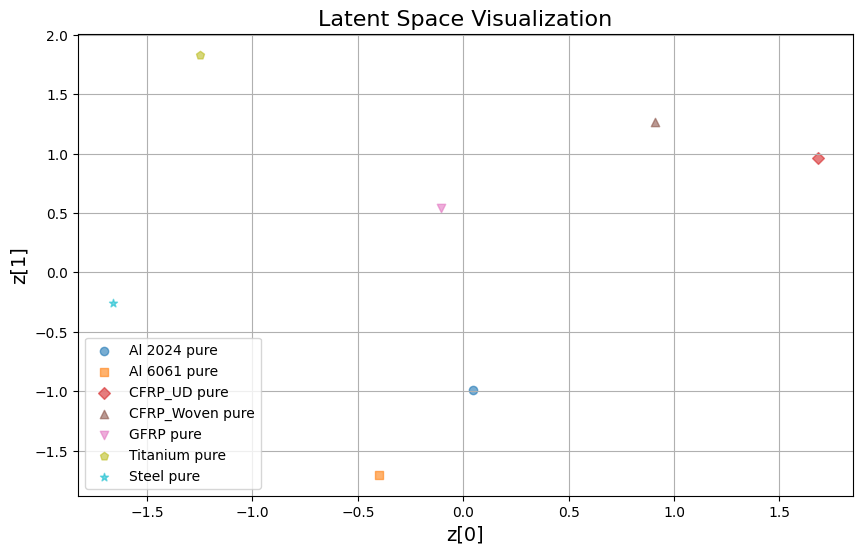

In [7]:
import matplotlib.cm as cm
from matplotlib.lines import Line2D

def plotLatent(autoencoder, dataInfo, dataIdentifier, plotHull=False, plotEllipse=False, save_path='./figures/latent_space_plot_7_pures.png'):
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    colorcol = dataIdentifier['classID'].to_numpy()

    class_ids = np.unique(colorcol)
    num_classes = len(class_ids)
    
    # Color and marker assignment
    clrs = cm.tab10(np.linspace(0, 1, num_classes))  # enough for 10 classes
    mrkrSet = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', '+', 'x']
    
    plt.figure(figsize=(10, 6))

    for i, class_id in enumerate(class_ids):
        idxs = np.where(colorcol == class_id)[0]
        points = z[idxs, :]
        
        plt.scatter(points[:, 0], points[:, 1], c=[clrs[i]], marker=mrkrSet[i % len(mrkrSet)], label=dataIdentifier['material'][colorcol == class_id].iloc[0], alpha=0.6)

        if plotHull and len(points) >= 3:
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'k-', linewidth=0.5)

        if plotEllipse and len(points) > 1:
            cov = np.cov(points.T)
            vals, vecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
            width, height = 2 * np.sqrt(vals)
            mean = np.mean(points, axis=0)
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='k', fc='None', lw=1.5, ls='--')
            plt.gca().add_patch(ellipse)

    plt.xlabel('z[0]', fontsize=14)
    plt.ylabel('z[1]', fontsize=14)
    plt.title('Latent Space Visualization', fontsize=16)
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PNG file
    plt.savefig(save_path, format='png', dpi=300)  # Adjust dpi for higher resolution if needed

    # Optionally display the plot as well
    plt.show()

# Example usage:
plotLatent(materialEncoder.vaeNet, dataInfo, dataIdentifier, plotHull=True, plotEllipse=True, save_path='./figures/latent_space_plot_7.png')


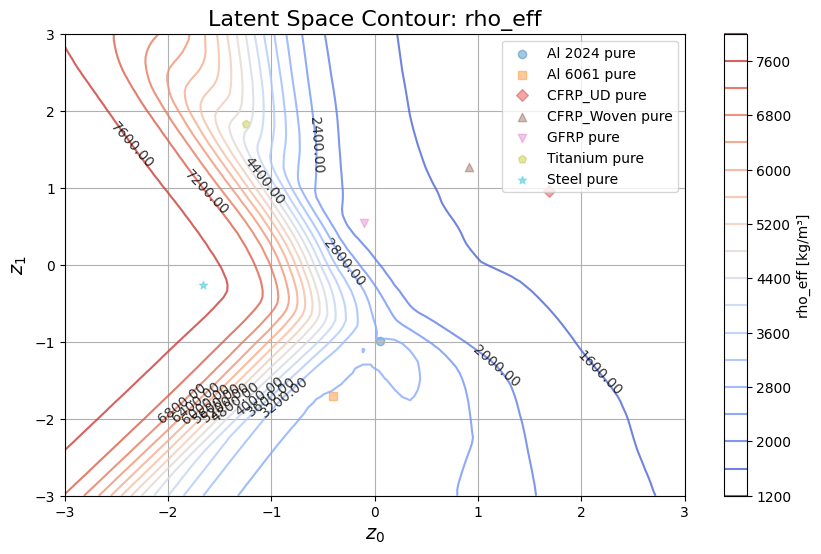

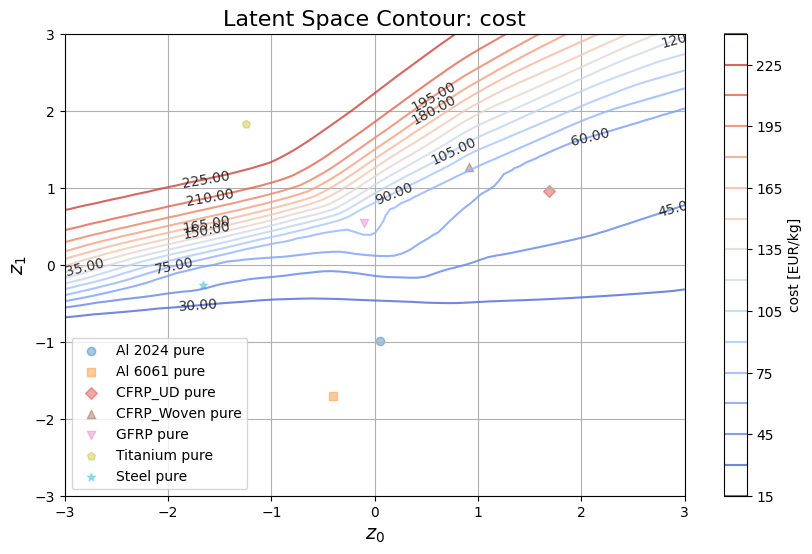

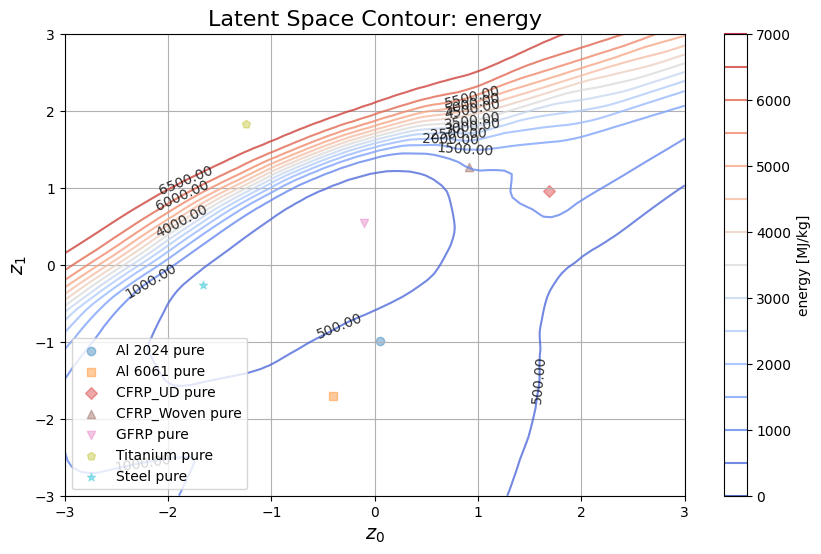

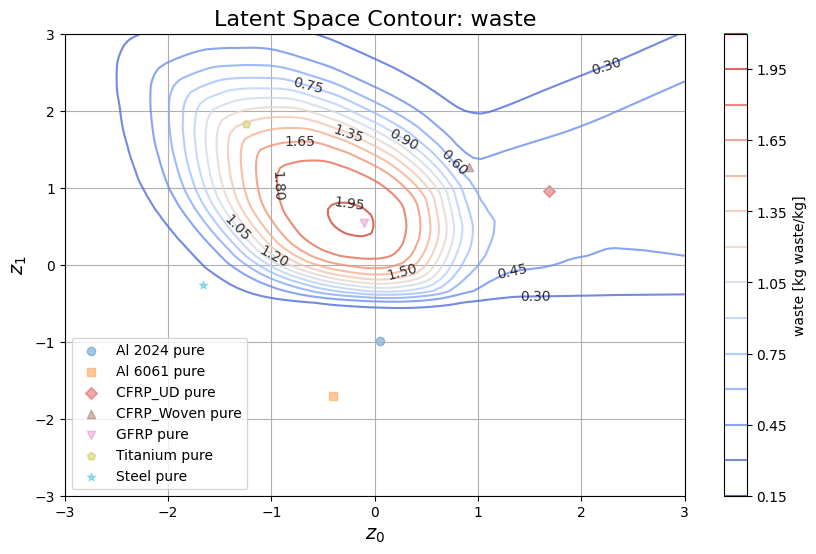

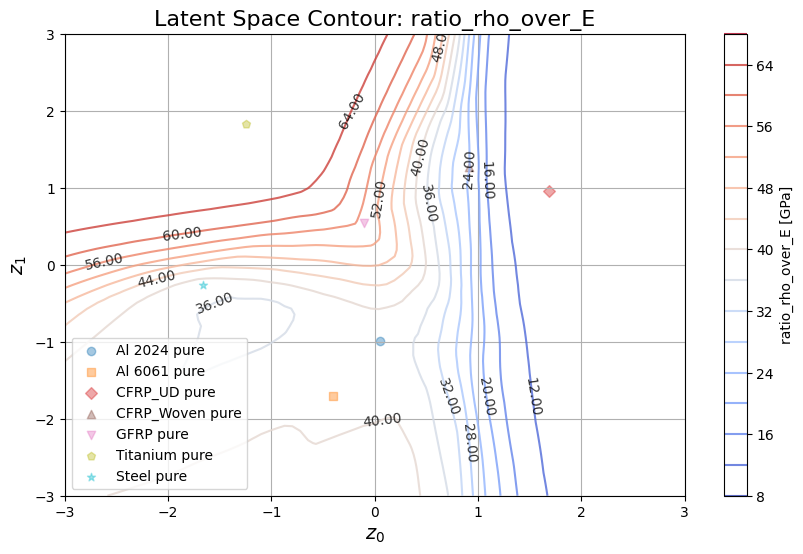

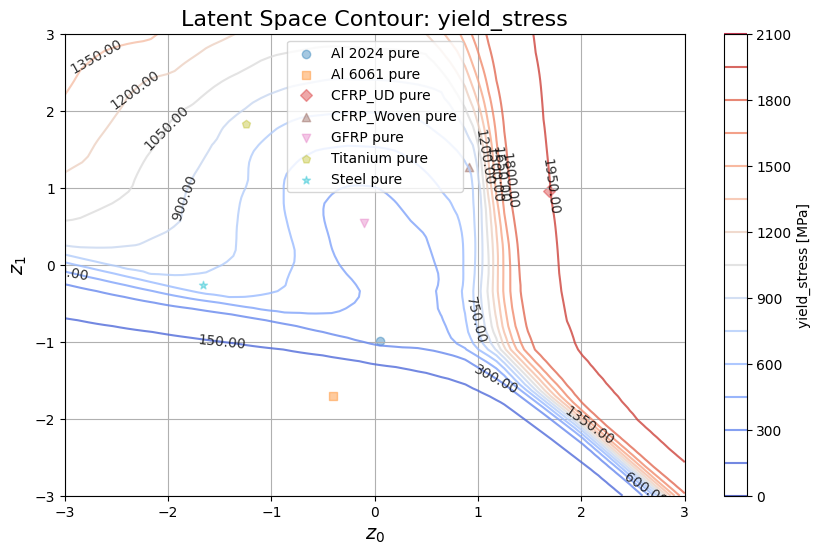

In [8]:
def plotLatentProperty(autoencoder, dataInfo, property_name='rho_eff', ltnt1=0, ltnt2=1,
                       grid_size=80, zmin=-3, zmax=3, contour_levels=15,
                       plotHull=False, plotEllipse=True, save_path=None, show_plot=True):
    import matplotlib.pyplot as plt

    # Prepare latent grid
    X, Y = np.meshgrid(np.linspace(zmin, zmax, grid_size), np.linspace(zmin, zmax, grid_size))
    Z = torch.zeros((grid_size**2, autoencoder.encoder.z.shape[1])).to('cpu')
    Z[:, ltnt1], Z[:, ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))

    # Decode property
    with torch.no_grad():
        decoded = autoencoder.decoder(Z)
    decoded_np = to_np(decoded)

    # Property scaling
    idx = dataInfo[property_name]['idx']
    scaleMin = float(dataInfo[property_name]['scaleMin'])
    scaleMax = float(dataInfo[property_name]['scaleMax'])
    prop_vals = 10. ** (scaleMin + decoded_np[:, idx] * (scaleMax - scaleMin))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Optionally overlay latent points and families
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    colorcol = dataIdentifier['classID'].to_numpy()
    class_ids = np.unique(colorcol)
    clrs = cm.tab10(np.linspace(0, 1, len(class_ids)))
    mrkrSet = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', '+', 'x']

    for i, class_id in enumerate(class_ids):
        idxs = np.where(colorcol == class_id)[0]
        points = z[idxs, :]
        ax.scatter(points[:, ltnt1], points[:, ltnt2], c=[clrs[i]], 
                   marker=mrkrSet[i % len(mrkrSet)], 
                   label=dataIdentifier['material'][colorcol == class_id].iloc[0], alpha=0.4)

        if plotHull and len(points) >= 3:
            hull = ConvexHull(points[:, [ltnt1, ltnt2]])
            for simplex in hull.simplices:
                ax.plot(points[simplex, ltnt1], points[simplex, ltnt2], 'k-', linewidth=0.5)

        if plotEllipse and len(points) > 1:
            cov = np.cov(points[:, [ltnt1, ltnt2]].T)
            vals, vecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
            width, height = 2 * np.sqrt(vals)
            mean = np.mean(points[:, [ltnt1, ltnt2]], axis=0)
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                              edgecolor='k', fc='None', lw=1.5, ls='--')
            ax.add_patch(ellipse)

    # Contour plot of the property
    # Unit labels for each property
    property_units = {
        'rho_eff': 'kg/m³',
        'cost': 'EUR/kg',
        'energy': 'MJ/kg',
        'waste': 'kg waste/kg',
        'ratio_rho_over_E': 'GPa',
        'yield_stress': 'MPa'
    }
    prop_grid = prop_vals.reshape((grid_size, grid_size))
    contour = ax.contour(X, Y, prop_grid, levels=contour_levels, cmap='coolwarm', alpha=0.8)
    plt.clabel(contour, inline=False, fontsize=10, fmt='%0.2f', colors='black')
    cbar = plt.colorbar(contour)
    unit = property_units.get(property_name, '')
    cbar.set_label(f'{property_name} [{unit}]')


    ax.set_xlabel(f'$z_{ltnt1}$', fontsize=14)
    ax.set_ylabel(f'$z_{ltnt2}$', fontsize=14)
    ax.set_title(f'Latent Space Contour: {property_name}', fontsize=16)
    ax.legend()
    ax.grid(True)

    # Save and/or show
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    if show_plot:
        plt.show()
    else:
        plt.close()

plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='rho_eff',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/rho_eff_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='cost',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/cost_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='energy',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/energy_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='waste',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/waste_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='ratio_rho_over_E',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/ratio_rho_over_E_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='yield_stress',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/yield_stress_latentField_7.pdf'
)


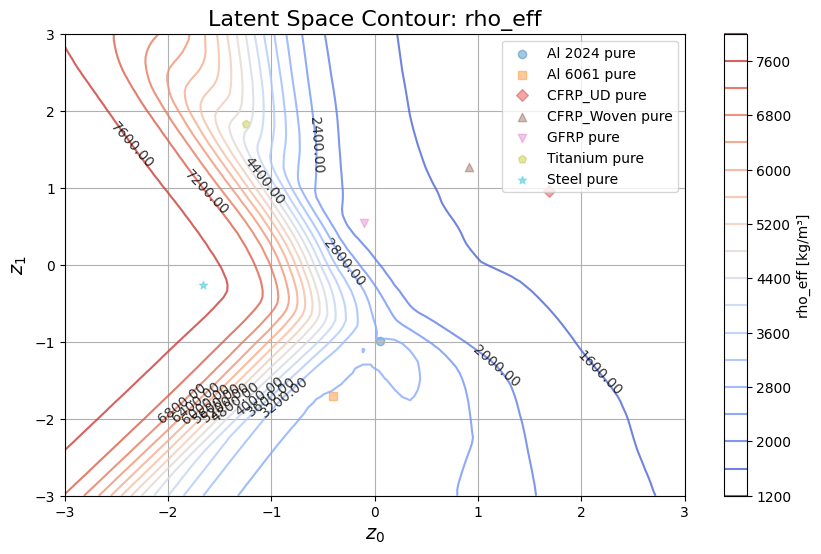

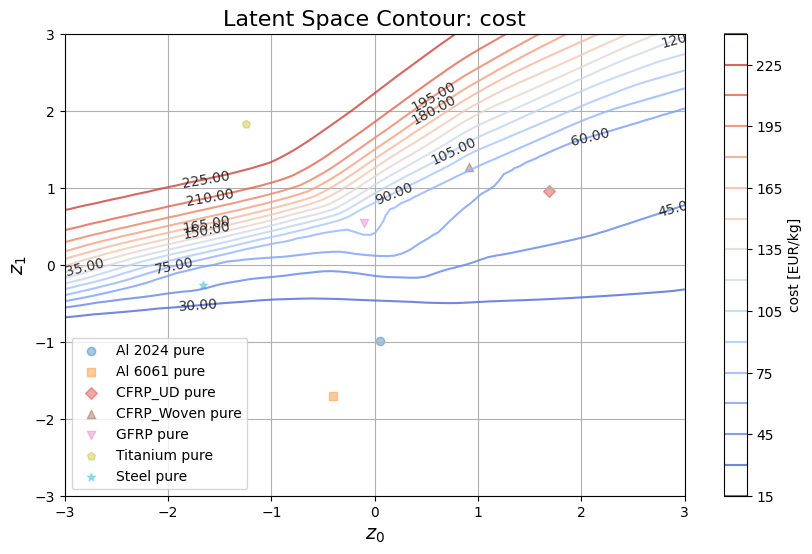

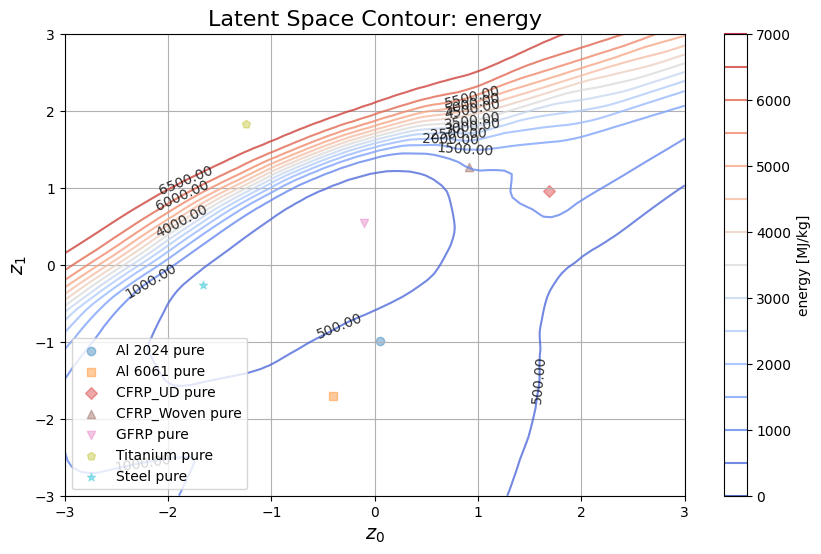

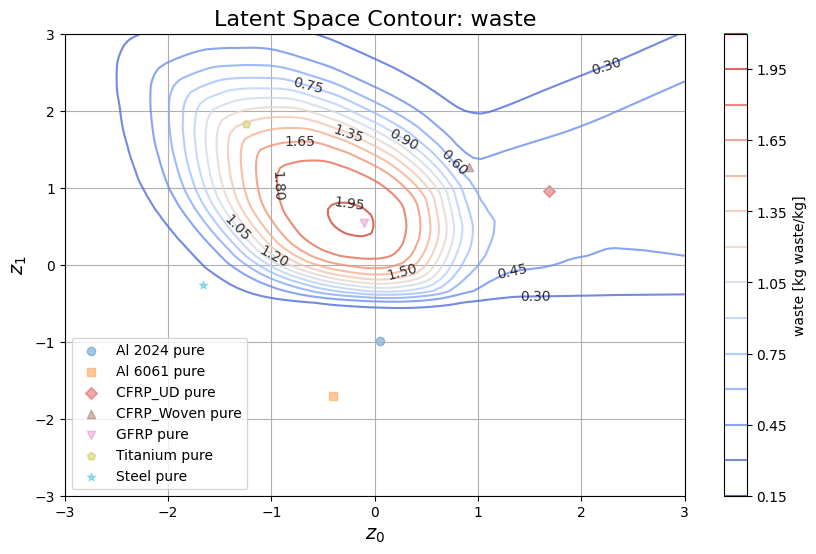

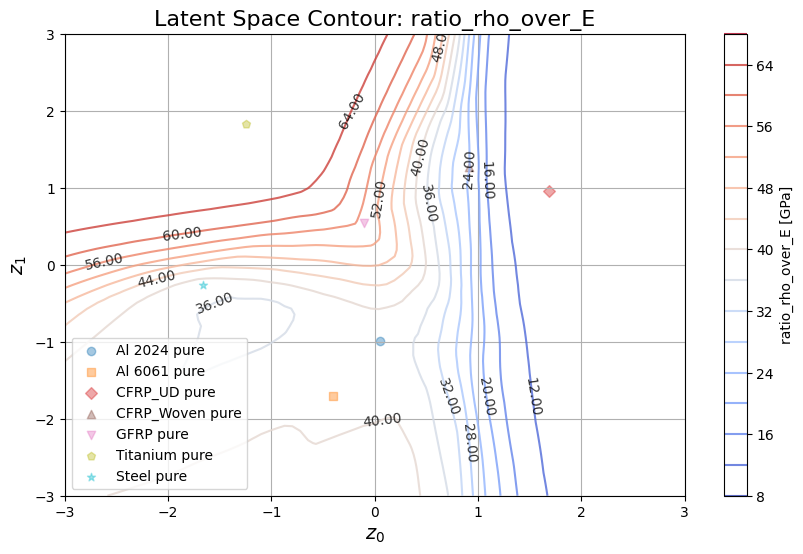

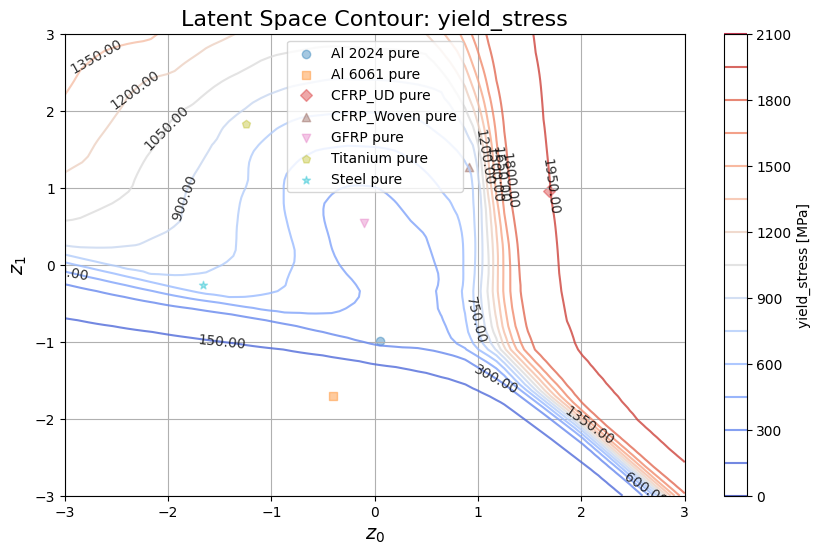

In [9]:
def plotLatentProperty(autoencoder, dataInfo, property_name='rho_eff', ltnt1=0, ltnt2=1,
                       grid_size=80, zmin=-3, zmax=3, contour_levels=15,
                       plotHull=False, plotEllipse=True, save_path=None, show_plot=True):
    import matplotlib.pyplot as plt

    # Prepare latent grid
    X, Y = np.meshgrid(np.linspace(zmin, zmax, grid_size), np.linspace(zmin, zmax, grid_size))
    Z = torch.zeros((grid_size**2, autoencoder.encoder.z.shape[1])).to('cpu')
    Z[:, ltnt1], Z[:, ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))

    # Decode property
    with torch.no_grad():
        decoded = autoencoder.decoder(Z)
    decoded_np = to_np(decoded)

    # Property scaling
    idx = dataInfo[property_name]['idx']
    scaleMin = float(dataInfo[property_name]['scaleMin'])
    scaleMax = float(dataInfo[property_name]['scaleMax'])
    prop_vals = 10. ** (scaleMin + decoded_np[:, idx] * (scaleMax - scaleMin))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Optionally overlay latent points and families
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    colorcol = dataIdentifier['classID'].to_numpy()
    class_ids = np.unique(colorcol)
    clrs = cm.tab10(np.linspace(0, 1, len(class_ids)))
    mrkrSet = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', '+', 'x']

    for i, class_id in enumerate(class_ids):
        idxs = np.where(colorcol == class_id)[0]
        points = z[idxs, :]
        ax.scatter(points[:, ltnt1], points[:, ltnt2], c=[clrs[i]], 
                   marker=mrkrSet[i % len(mrkrSet)], 
                   label=dataIdentifier['material'][colorcol == class_id].iloc[0], alpha=0.4)

        if plotHull and len(points) >= 3:
            hull = ConvexHull(points[:, [ltnt1, ltnt2]])
            for simplex in hull.simplices:
                ax.plot(points[simplex, ltnt1], points[simplex, ltnt2], 'k-', linewidth=0.5)

        if plotEllipse and len(points) > 1:
            cov = np.cov(points[:, [ltnt1, ltnt2]].T)
            vals, vecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
            width, height = 2 * np.sqrt(vals)
            mean = np.mean(points[:, [ltnt1, ltnt2]], axis=0)
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                              edgecolor='k', fc='None', lw=1.5, ls='--')
            ax.add_patch(ellipse)

    # Contour plot of the property
    # Unit labels for each property
    property_units = {
        'rho_eff': 'kg/m³',
        'cost': 'EUR/kg',
        'energy': 'MJ/kg',
        'waste': 'kg waste/kg',
        'ratio_rho_over_E': 'GPa',
        'yield_stress': 'MPa'
    }
    prop_grid = prop_vals.reshape((grid_size, grid_size))
    contour = ax.contour(X, Y, prop_grid, levels=contour_levels, cmap='coolwarm', alpha=0.8)
    plt.clabel(contour, inline=False, fontsize=10, fmt='%0.2f', colors='black')
    cbar = plt.colorbar(contour)
    unit = property_units.get(property_name, '')
    cbar.set_label(f'{property_name} [{unit}]')


    ax.set_xlabel(f'$z_{ltnt1}$', fontsize=14)
    ax.set_ylabel(f'$z_{ltnt2}$', fontsize=14)
    ax.set_title(f'Latent Space Contour: {property_name}', fontsize=16)
    ax.legend()
    ax.grid(True)

    # Save and/or show
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    if show_plot:
        plt.show()
    else:
        plt.close()

plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='rho_eff',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/rho_eff_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='cost',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/cost_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='energy',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/energy_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='waste',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/waste_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='ratio_rho_over_E',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/ratio_rho_over_E_latentField_7.pdf'
)
plotLatentProperty(
    autoencoder=materialEncoder.vaeNet,
    dataInfo=materialEncoder.dataInfo,
    property_name='yield_stress',
    ltnt1=0,
    ltnt2=1,
    plotHull=True,
    plotEllipse=True,
    save_path='./figures/yield_stress_latentField_7.pdf'
)



Running MGDA 500 times...
Converged at step 81, Δz = 0.00e+00
Converged at step 0, Δz = 0.00e+00
Converged at step 128, Δz = 0.00e+00
Converged at step 1, Δz = 0.00e+00
Converged at step 101, Δz = 4.00e-07
Converged at step 15, Δz = 5.96e-08
Converged at step 0, Δz = 2.98e-08
Converged at step 1, Δz = 0.00e+00
Converged at step 0, Δz = 0.00e+00
Converged at step 103, Δz = 1.90e-06
Converged at step 143, Δz = 1.04e-07
Converged at step 0, Δz = 0.00e+00
Converged at step 1, Δz = 1.55e-06
Converged at step 0, Δz = 2.53e-07
Converged at step 1, Δz = 2.15e-06
Converged at step 0, Δz = 0.00e+00
Converged at step 138, Δz = 0.00e+00
Converged at step 0, Δz = 0.00e+00
Converged at step 0, Δz = 5.96e-08
Converged at step 1, Δz = 0.00e+00
Converged at step 1, Δz = 2.21e-06
Converged at step 0, Δz = 0.00e+00
Converged at step 0, Δz = 0.00e+00
Converged at step 85, Δz = 0.00e+00
Converged at step 43, Δz = 1.49e-08
Converged at step 0, Δz = 0.00e+00
Converged at step 0, Δz = 0.00e+00
Converged at s

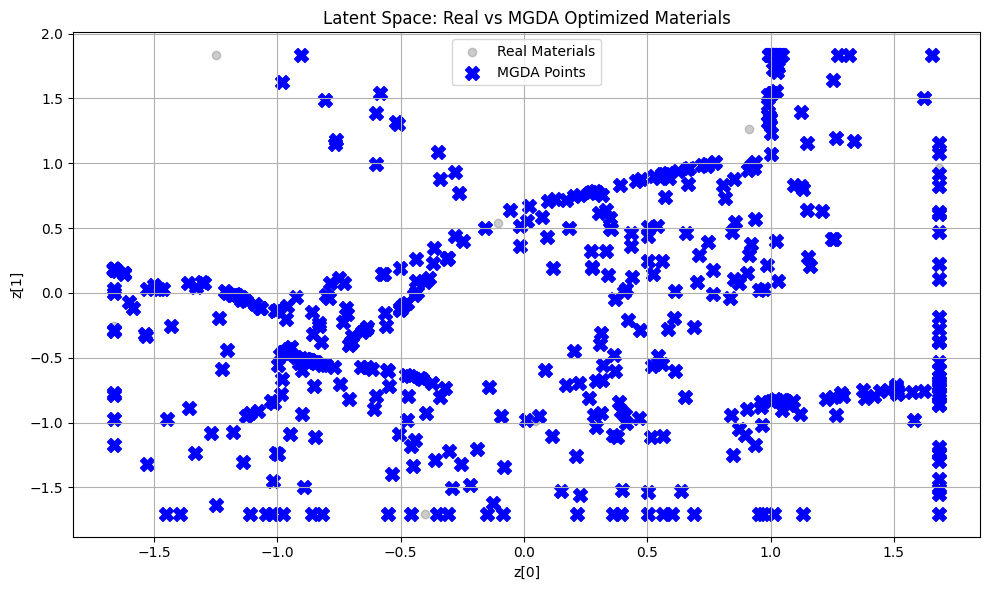

In [10]:
from itertools import product
from torch.autograd import grad
from cvxopt import matrix, solvers  # Make sure this is installed


# === Required inputs ===
vae = materialEncoder.vaeNet
decoder = vae.decoder
z_np = vae.encoder.z.detach().cpu().numpy()
z_np_tensor = torch.tensor(z_np)
props_to_optimize = [ 'cost', 'energy', 'waste', 'ratio_rho_over_E', 'yield_stress']
maximize_props = {'yield_stress'}
latent_dim = vae.encoder.z.shape[1]

z_min = torch.tensor(np.min(z_np, axis=0), dtype=torch.float32)
z_max = torch.tensor(np.max(z_np, axis=0), dtype=torch.float32)

# === Utility functions ===
def unnormalize(val, minval, maxval):
    return 10. ** (minval + (maxval - minval) * val)

def to_cvxopt_matrix(X):
    return matrix(X.astype(np.double))

# === MGDA optimization ===
def optimize_mgda(penalty_lambda=2.0, steps=300, tol=1e-5):
    z = torch.nn.Parameter(torch.randn(1, latent_dim), requires_grad=True)
    optimizer = torch.optim.SGD([z], lr=0.01)

    prev_z = z.clone().detach()

    for step in range(steps):
        optimizer.zero_grad()
        decoded = decoder(z).squeeze()

        grads = []
        for prop in props_to_optimize:
            idx = dataInfo[prop]['idx']
            minv = dataInfo[prop]['scaleMin']
            maxv = dataInfo[prop]['scaleMax']
            val = unnormalize(decoded[idx], minv, maxv)
            val = -val if prop in maximize_props else val
            g = grad(val, z, retain_graph=True)[0]
            grads.append(g)

        grads = torch.stack(grads).squeeze()
        G = grads.detach().cpu().numpy()
        GGt = G @ G.T

        P = to_cvxopt_matrix(GGt)
        q = to_cvxopt_matrix(np.zeros(G.shape[0]))
        A = to_cvxopt_matrix(np.ones((1, G.shape[0])))
        b = to_cvxopt_matrix(np.array([1.0]))
        G_ineq = to_cvxopt_matrix(-np.eye(G.shape[0]))
        h_ineq = to_cvxopt_matrix(np.zeros(G.shape[0]))

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G_ineq, h_ineq, A, b)
        w_opt = np.array(sol['x']).flatten()
        w_opt = torch.tensor(w_opt, dtype=torch.float32)

        total_grad = torch.sum(w_opt[:, None] * grads, dim=0)
        z.grad = total_grad.unsqueeze(0)
        optimizer.step()

        with torch.no_grad():
            z.data = torch.max(torch.min(z, z_max), z_min)

            # === Convergence criterion ===
            delta = torch.norm(z - prev_z)
            if delta < tol:
                print(f"Converged at step {step}, Δz = {delta:.2e}")
                break
            prev_z = z.clone().detach()

    return z.detach().numpy(), decoder(z).squeeze().detach()


# === Run MGDA multiple times ===
results = []
n_runs = 500
print(f"\nRunning MGDA {n_runs} times...")
for i in range(n_runs):
    z_star, decoded = optimize_mgda(penalty_lambda=2.0, steps=300)
    decoded_true_vals = {
        prop: unnormalize(
            decoded[dataInfo[prop]['idx']],
            dataInfo[prop]['scaleMin'],
            dataInfo[prop]['scaleMax']
        ).item()
        for prop in props_to_optimize + ['rho_eff']
    }
    results.append({'weights': 'MGDA', 'z': z_star[0], 'decoded': decoded_true_vals})

# === Print Summary ===
print("\n--- MGDA Pareto Approximation Summary ---")
for r in results:
    print(f"Weights: {r['weights']}")
    for prop, val in r['decoded'].items():
        print(f"  {prop:10s}: {val:.4f}")
    print()

# === Plot Latent Space ===
z_real = z_np
z_mgda = np.array([r['z'] for r in results])

plt.figure(figsize=(10, 6))
plt.scatter(z_real[:, 0], z_real[:, 1], alpha=0.4, label="Real Materials", c='gray')
plt.scatter(z_mgda[:, 0], z_mgda[:, 1], c='blue', marker='X', s=100, label="MGDA Points")

plt.title("Latent Space: Real vs MGDA Optimized Materials")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/latent_space_mgda_pareto_front.png", dpi=300)
plt.show()


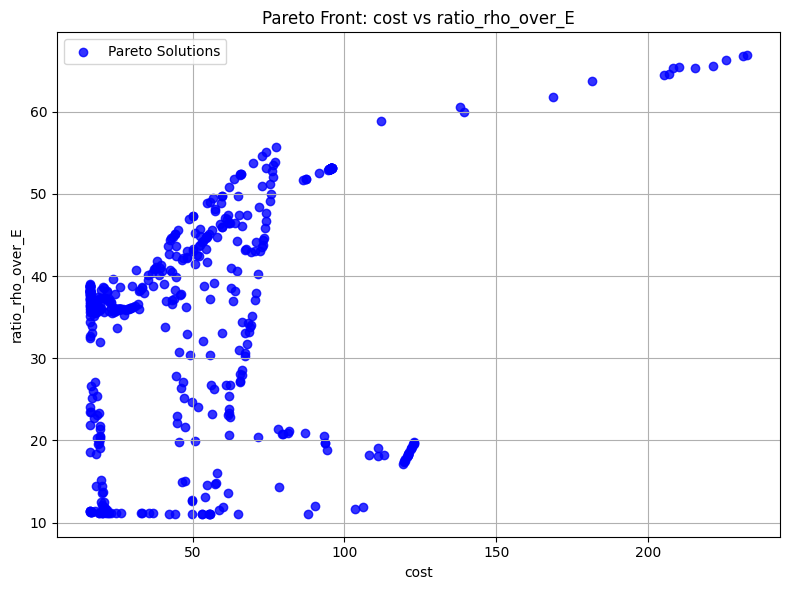

In [11]:
import matplotlib.pyplot as plt

# === Choose the two properties you want to plot ===
x_prop = 'cost'  # Example property for x-axis
y_prop = 'ratio_rho_over_E'

# === Extract data ===
x_vals = [r['decoded'][x_prop] for r in results]
y_vals = [r['decoded'][y_prop] for r in results]

# === Plot ===
plt.figure(figsize=(8, 6))
plt.scatter(x_vals, y_vals, c='blue', label='Pareto Solutions', alpha=0.8)
plt.xlabel(x_prop)
plt.ylabel(y_prop)
plt.title(f"Pareto Front: {x_prop} vs {y_prop}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./figures/pareto_front_cost_rho_eff.png", dpi=300)
plt.show()


In [12]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from scipy.interpolate import UnivariateSpline

# ---------------------
# Define your function
# ---------------------
def plotly_pareto_from_results_with_full_interpolation(
        results,
        x_prop, y_prop, color_prop,
        maximize_x=False, maximize_y=False,
        degree=2
):
    data = pd.DataFrame([r['decoded'] for r in results])

    # Compute Young's modulus and add it to the DataFrame
    data['young_modulus'] = data['rho_eff'] / data['ratio_rho_over_E']

    # Define all hover properties (including derived one)
    all_properties = ['rho_eff', 'cost', 'energy', 'waste', 'ratio_rho_over_E', 'yield_stress', 'young_modulus']

    x_vals = data[x_prop].values
    y_vals = data[y_prop].values
    color_vals = data[color_prop].values

    objs = np.vstack([
        -x_vals if maximize_x else x_vals,
        -y_vals if maximize_y else y_vals
    ]).T

    nds = NonDominatedSorting()
    pareto_idx = nds.do(objs, only_non_dominated_front=True)

    pareto_df = data.iloc[pareto_idx].copy()
    pareto_df['x'] = pareto_df[x_prop]
    pareto_df['y'] = pareto_df[y_prop]
    pareto_df['color'] = pareto_df[color_prop]

    pareto_df.sort_values('x', inplace=True)

    x_sorted = pareto_df['x'].values
    y_sorted = pareto_df['y'].values

    # Remove duplicates before interpolation
    x_unique, idx_unique = np.unique(x_sorted, return_index=True)
    y_unique = y_sorted[idx_unique]

    spline = UnivariateSpline(x_unique, y_unique, k=min(degree, 3), s=0)
    x_interp = np.linspace(x_unique.min(), x_unique.max(), 200)
    y_interp = spline(x_interp)

    # Interpolate all properties
    interpolated_props = {}
    for prop in all_properties:
        y_vals_prop = pareto_df[prop].values
        y_unique_prop = y_vals_prop[idx_unique]
        spline_prop = UnivariateSpline(x_unique, y_unique_prop, k=min(degree, 3), s=0)
        interpolated_props[prop] = spline_prop(x_interp)

    # Add interpolated line to DataFrame
    interp_df = pd.DataFrame(interpolated_props)
    interp_df['x'] = x_interp
    interp_df['y'] = y_interp
    interp_df['color'] = interpolated_props[color_prop]

    # Interactive plotly
    fig = px.scatter(
        pareto_df, x='x', y='y', color='color',
        color_continuous_scale='viridis',
        hover_data=all_properties,
        labels={'x': x_prop, 'y': y_prop, 'color': color_prop},
        title=f"Pareto front: {x_prop} vs {y_prop} (colored by {color_prop})"
    )

    # Add interpolated trace
    fig.add_trace(
        go.Scatter(
            x=interp_df['x'],
            y=interp_df['y'],
            mode='lines',
            name='Interpolated Pareto',
            line=dict(color='black'),
            text=[
                '<br>'.join([f'{prop}: {val:.3f}' for prop, val in row.items()])
                for row in interp_df[all_properties].to_dict(orient='records')
            ],
            hoverinfo='text'
        )
    )

    fig.update_traces(marker=dict(size=10, line=dict(width=1, color='black')))
    fig.show()



plotly_pareto_from_results_with_full_interpolation(
    results,
    x_prop='cost',
    y_prop='ratio_rho_over_E',
    color_prop='energy',
    maximize_x=False,
    maximize_y=False,
    degree=1
)
plotly_pareto_from_results_with_full_interpolation(
    results,
    x_prop='energy',
    y_prop='ratio_rho_over_E',
    color_prop='cost',
    maximize_x=False,
    maximize_y=False,
    degree=1
)


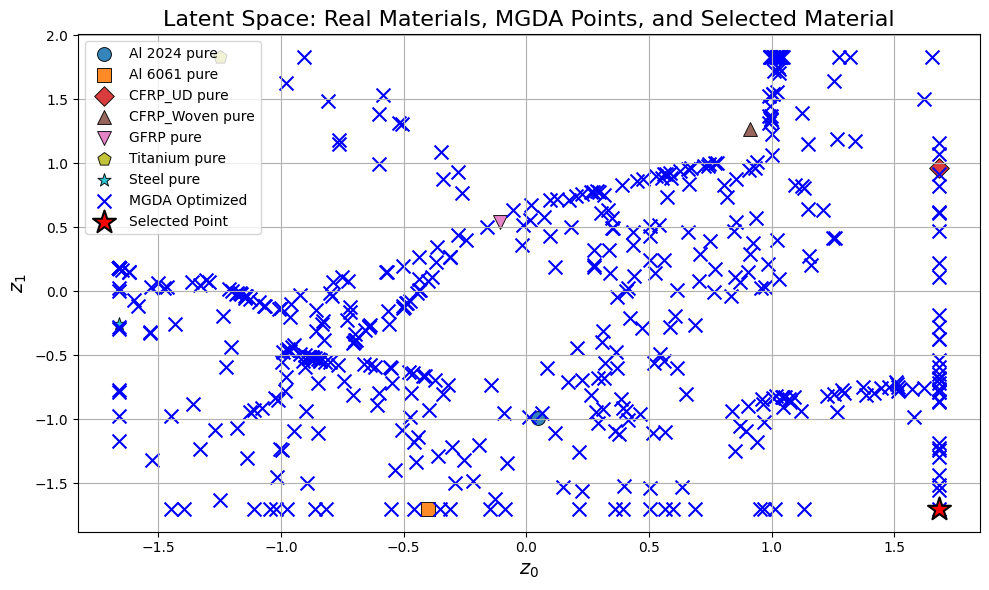

In [13]:

# === 1. Define your selected point ===
selected_properties = {
    "energy": 467.31,
    "ratio_rho_over_E": 11.40,
    "rho_eff": 1790.97,
    "cost": 16.24,
    "waste": 0.20,
    "yield_stress": 1129.31,
}

# === 2. Find closest latent vector to selected properties ===
selected_z = None
min_diff = float('inf')

for r in results:
    decoded = r['decoded']
    dist = sum(abs(decoded[k] - selected_properties[k]) for k in selected_properties)
    if dist < min_diff:
        min_diff = dist
        selected_z = r['z']

z_selected = np.array(selected_z).reshape(1, -1)

# === 3. Plot all in latent space ===
def plot_latent_with_selected_point(z_real, class_ids, class_labels, z_mgda, z_selected, save_path=None):
    num_classes = len(np.unique(class_ids))
    clrs = cm.tab10(np.linspace(0, 1, num_classes))
    mrkrSet = ['o', 's', 'D', '^', 'v', 'p', '*', 'h', '+', 'x']

    plt.figure(figsize=(10, 6))

    # Plot real material classes
    for i, cls in enumerate(np.unique(class_ids)):
        idxs = np.where(class_ids == cls)[0]
        points = z_real[idxs, :]
        label = class_labels[cls] if cls in class_labels else f"Class {cls}"
        plt.scatter(points[:, 0], points[:, 1],
                    c=[clrs[i]],
                    marker=mrkrSet[i % len(mrkrSet)],
                    label=label,
                    alpha=0.9,
                    s=100,
                    edgecolors='black',
                    linewidths=0.7)

    # Plot MGDA optimized points
    plt.scatter(z_mgda[:, 0], z_mgda[:, 1],
                c='blue', marker='x', s=100, label='MGDA Optimized')

    # Plot the selected point
    plt.scatter(z_selected[:, 0], z_selected[:, 1],
                c='red', marker='*', s=300, label='Selected Point', edgecolors='black', linewidths=1.5)

    plt.xlabel("$z_0$", fontsize=14)
    plt.ylabel("$z_1$", fontsize=14)
    plt.title("Latent Space: Real Materials, MGDA Points, and Selected Material", fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

# === 4. Call the function with your data ===
plot_latent_with_selected_point(
    z_real=z_np,
    class_ids=dataIdentifier['classID'].to_numpy(),
    class_labels=dict(enumerate(dataIdentifier['material'].unique())),
    z_mgda=np.array([r['z'] for r in results]),
    z_selected=z_selected,
    save_path="./figures/latent_space_selected_point.png"
)
